In [1]:
import os
import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from transformers import DeiTForImageClassification, DeiTImageProcessor
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Defining image transformations
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),      
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1), 
    transforms.RandomRotation(20),          
    transforms.Resize((224, 224)),         
    transforms.ToTensor(),                  
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 
])

# Loading the dataset
data_dir = 'dataset'
full_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

# Divide the dataset
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(full_dataset.classes)


['FLOWER', 'POD', 'SEED']


In [2]:
import torch
from transformers import DeiTForImageClassification, DeiTFeatureExtractor

# Loading the DeiT pre-trained model and feature extractor
model_name = "facebook/deit-base-distilled-patch16-224"
feature_extractor = DeiTImageProcessor.from_pretrained(model_name)
model = DeiTForImageClassification.from_pretrained(model_name, num_labels=3)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Defining loss function and optimizer
criterion = CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
num_epochs = 15


# Training the model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")

    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradient
        optimizer.zero_grad()

        # Forward Propagation
        outputs = model(pixel_values=inputs).logits
        loss = criterion(outputs, labels)

        # Back Propagation
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_loader_tqdm.set_postfix(loss=running_loss / len(train_loader), accuracy=train_accuracy)

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(pixel_values=inputs).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}%")

print("Finished Training")

Epoch 1/15:   0%|          | 0/20 [00:00<?, ?batch/s]c:\Users\wjc20\miniconda3\envs\ml\Lib\site-packages\transformers\models\deit\modeling_deit.py:254: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(
Epoch 1/15: 100%|██████████| 20/20 [13:34<00:00, 40.70s/batch, accuracy=85.8, loss=0.33] 


Validation Loss: 0.02099297133584817, Validation Accuracy: 100.0%


Epoch 2/15: 100%|██████████| 20/20 [14:45<00:00, 44.28s/batch, accuracy=99.4, loss=0.0191] 


Validation Loss: 0.00210056504389892, Validation Accuracy: 100.0%


Epoch 3/15: 100%|██████████| 20/20 [14:30<00:00, 43.50s/batch, accuracy=99.8, loss=0.00754]


Validation Loss: 0.001895205699838698, Validation Accuracy: 100.0%


Epoch 4/15: 100%|██████████| 20/20 [13:39<00:00, 40.96s/batch, accuracy=99.8, loss=0.00688]


Validation Loss: 0.001097394172878315, Validation Accuracy: 100.0%


Epoch 5/15: 100%|██████████| 20/20 [13:54<00:00, 41.74s/batch, accuracy=100, loss=0.00544]


Validation Loss: 0.001550009474158287, Validation Accuracy: 100.0%


Epoch 6/15: 100%|██████████| 20/20 [14:25<00:00, 43.26s/batch, accuracy=100, loss=0.0022]  


Validation Loss: 0.0010989774018526077, Validation Accuracy: 100.0%


Epoch 7/15: 100%|██████████| 20/20 [16:56<00:00, 50.83s/batch, accuracy=100, loss=0.00281] 


Validation Loss: 0.000917113017446051, Validation Accuracy: 100.0%


Epoch 8/15: 100%|██████████| 20/20 [16:26<00:00, 49.35s/batch, accuracy=100, loss=0.00262]


Validation Loss: 0.0008137472905218601, Validation Accuracy: 100.0%


Epoch 9/15: 100%|██████████| 20/20 [14:21<00:00, 43.07s/batch, accuracy=100, loss=0.00209]


Validation Loss: 0.0010872940086604406, Validation Accuracy: 100.0%


Epoch 10/15: 100%|██████████| 20/20 [14:03<00:00, 42.17s/batch, accuracy=100, loss=0.00185] 


Validation Loss: 0.0007163930373887221, Validation Accuracy: 100.0%


Epoch 11/15: 100%|██████████| 20/20 [13:50<00:00, 41.54s/batch, accuracy=100, loss=0.00194]


Validation Loss: 0.0008436652957849825, Validation Accuracy: 100.0%


Epoch 12/15: 100%|██████████| 20/20 [14:02<00:00, 42.11s/batch, accuracy=100, loss=0.00191] 


Validation Loss: 0.0004488758762211849, Validation Accuracy: 100.0%


Epoch 13/15: 100%|██████████| 20/20 [13:58<00:00, 41.93s/batch, accuracy=100, loss=0.00167]


Validation Loss: 0.000445838183319817, Validation Accuracy: 100.0%


Epoch 14/15: 100%|██████████| 20/20 [13:55<00:00, 41.77s/batch, accuracy=100, loss=0.00153] 


Validation Loss: 0.0005374106985982507, Validation Accuracy: 100.0%


Epoch 15/15: 100%|██████████| 20/20 [13:52<00:00, 41.64s/batch, accuracy=100, loss=0.00137] 


Validation Loss: 0.0006107497805108627, Validation Accuracy: 100.0%
Finished Training


In [5]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Testing the Model
model.eval()
test_loss = 0.0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(pixel_values=inputs).logits
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate the average test loss
test_loss /= len(test_loader)

# Calculating evaluation metrics
accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')

print(f"Test Loss: {test_loss}")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")


Test Loss: 0.00011055697662717041
Accuracy: 100.00%
F1 Score: 1.00
Recall: 1.00
Precision: 1.00


In [18]:
torch.save(model.state_dict(), 'deit_flower_pod_seed_model.pth')


In [6]:
from PIL import Image
import numpy as np

# Defining the prediction function
def predict(image_path, model, feature_extractor, classes):
    model.eval()

    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs).logits
        _, predicted = torch.max(outputs, 1)
        return classes[predicted.item()]

# Making predictions
image_path = 'Flower28.jpg'
classes = full_dataset.classes
predicted_class = predict(image_path, model, feature_extractor, classes)
print(f"Predicted class: {predicted_class}")


Predicted class: FLOWER


['flower', 'pod', 'seed']


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\wjc20\AppData\Local\Temp\ipykernel_4220\2039675431.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user

Test Loss: 0.10632749367505312
Accuracy: 99.03%
F1 Score: 0.9903
Recall: 0.9903
Precision: 0.9905


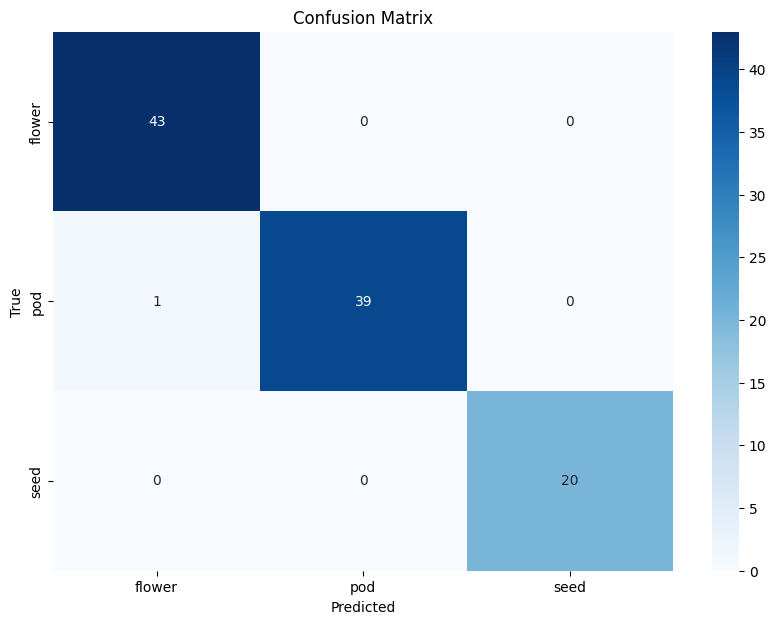

In [7]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import DeiTForImageClassification, DeiTImageProcessor
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import CrossEntropyLoss


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Loading a new dataset
data_dir = 'downloads'
test_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print class name
print(test_dataset.classes)
# Loading the DeiT pre-trained model and image processor
model_name = "facebook/deit-base-distilled-patch16-224"
image_processor = DeiTImageProcessor.from_pretrained(model_name)
model = DeiTForImageClassification.from_pretrained(model_name, num_labels=3)

# Load the trained model weights
model.load_state_dict(torch.load('deit_flower_pod_seed_model.pth'))


model = model.to(device)

# Define the loss function
criterion = CrossEntropyLoss()

# Testing the Model
model.eval()
test_loss = 0.0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(pixel_values=inputs).logits
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate the average test loss
test_loss /= len(test_loader)

# Calculating evaluation metrics
accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')

print(f"Test Loss: {test_loss}")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

# Plotting the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
